In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

# 获取数据进行统计分析

In [4]:
data = np.load('./Step4_DNN-alldata/databygroup.npy',allow_pickle=True).tolist()
datamaxmin=np.load('./Step4_DNN-alldata/databygroup_maxmin.npy',allow_pickle=True).tolist()

dmax = np.round(datamaxmin['max'][[-5,-4,-3,-2,-1]],2)
dmin = np.round(datamaxmin['min'][[-5,-4,-3,-2,-1]],2)
dmid = np.round((dmax+dmin)/2,2)

In [5]:
# ALL DATA
#聚类筛选的数据，从step5-1中直接复制
TrainData = {}
for k in data.keys():
    TrainData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
xtrain,ytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        xtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        ytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())
    #xtrain.append(xtem)
    #ytrain.append(ytem)
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
print(xtrain.shape,ytrain.shape)

(34684, 20, 15) (34684, 5)


In [6]:
# Selected DATA
selected_dataid = ['historydata', 'sub3', 'sub4', 'sub5', 'sub8', 'sub9', 'sub11', 'sub12', 'sub14', 
                   'sub19', 'sub21', 'sub24', 'sub25', 'sub26', 'sub31', 'sub35', 'sub37', 'sub39', 
                   'sub41', 'sub42', 'sub44', 'sub46', 'sub47', 'sub49', 'sub51', 'sub52', 'sub53', 
                   'sub56', 'sub58', 'sub59', 'sub61', 'sub63', 'sub68', 'sub70', 'sub73', 'sub74']

TrainData = {}
for k in selected_dataid:
    TrainData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
sxtrain,sytrain=[],[]
for k in TrainData.keys():
    for i in range(TrainData[k].shape[0]-step-1):
        sxtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        sytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())
    #xtrain.append(xtem)
    #ytrain.append(ytem)
sxtrain = np.array(sxtrain)
sytrain = np.array(sytrain)
print(sxtrain.shape,sytrain.shape)

(23032, 20, 15) (23032, 5)


In [7]:
# Scenario DATA

TrainData = {}
for k in data.keys():
    TrainData[k]=data[k]
        
#Tdata=TrainData[TrainData.keys()]
step=20
cxtrain,cytrain=[],[]
for k in TrainData.keys():
    for i in range(int(0.8*TrainData[k].shape[0])-step-1):
        cxtrain.append(TrainData[k][i:i+step,:TrainData[k].shape[1]-5].tolist())
        cytrain.append(TrainData[k][i+1+step,[-5,-4,-3,-2,-1]].tolist())

cxtrain = np.array(cxtrain)
cytrain = np.array(cytrain)


# data前4个feature分别为in NH4、TN、flow、COD、T，由此选TN and COD分类
# 找最大最小值

# 各分5份，构造选数据条件
n = 5
TNrange = np.linspace(np.max(xtrain[:,:,1]),np.min(xtrain[:,:,1]),n+1)
CODrange = np.linspace(np.max(xtrain[:,:,3]),np.min(xtrain[:,:,3]),n+1)

# 根据上述条件分数据，一共有25组数据
# 因为数据为20个时间步一条，所以用20个时间步的平均值作为分类条件

group_datax, group_datay = {}, {}

for TNid in range(len(TNrange)-1):
    for CODid in range(len(CODrange)-1):
        group_datax['TN'+str(TNid)+'_COD'+str(CODid)] = []
        group_datay['TN'+str(TNid)+'_COD'+str(CODid)] = []


for i in range(xtrain.shape[0]):
    meanTN, meanCOD = np.mean(xtrain[i,:,1]), np.mean(xtrain[i,:,3])
    logTN, logCOD = 0, 0
    # TN
    if meanTN == TNrange[0]:
        logTN = 0
    else:
        for k in range(len(TNrange)-1):
            if meanTN < TNrange[k] and meanTN >= TNrange[k+1]:
                logTN = k
    # COD
    if meanCOD == CODrange[0]:
        logCOD = 0
    else:
        for k in range(len(CODrange)-1):
            if meanCOD < CODrange[k] and meanCOD >= CODrange[k+1]:
                logCOD = k
    group_datax['TN'+str(logTN)+'_COD'+str(logCOD)].append(xtrain[i,:,:].tolist())
    group_datay['TN'+str(logTN)+'_COD'+str(logCOD)].append(ytrain[i,:].tolist())
    
# 删除没有数据的分组
logk = []
for k in group_datay.keys():
    if len(group_datay[k]) == 0:
        logk.append(k)

for k in logk:
    group_datax.pop(k)
    group_datay.pop(k)

# 从上述每个分组中选出代表性数据
# 在保证选出数据总数与Koopman方法一致的前提下，按照各个分类的比例选数据
# K方法选出的数据总共有 23032 条
# 确定每个分类的比例
num = {}
sumk = 0
for k in group_datay.keys():
    num[k] = len(group_datay[k])
    sumk += len(group_datay[k])

for k in group_datay.keys():
    num[k] = int(23032*num[k]/sumk)

cxtrain, cytrain = [], []
for k in group_datax.keys():
    for i in range(num[k]):
        cxtrain.append(group_datax[k][i])
        cytrain.append(group_datay[k][i])

cxtrain = np.array(cxtrain)
cytrain = np.array(cytrain)
print(cxtrain.shape,cytrain.shape)



(23024, 20, 15) (23024, 5)


# 数据均值、方差、中位数，分布图

In [8]:
y = (ytrain+1)*0.5*(dmax-dmin)+dmin
sy = (sytrain+1)*0.5*(dmax-dmin)+dmin
cy = (cytrain+1)*0.5*(dmax-dmin)+dmin

print(np.mean(y,axis=0))
print(np.mean(sy,axis=0))
print(np.mean(cy,axis=0))
print('########################################################')
print(np.var(y,axis=0))
print(np.var(sy,axis=0))
print(np.var(cy,axis=0))
print('########################################################')
print(np.median(y,axis=0))
print(np.median(sy,axis=0))
print(np.median(cy,axis=0))


[2.52180192e+01 8.50669529e+00 1.33577016e+03 1.04059997e+01
 5.53752974e-02]
[2.49678519e+01 8.30784081e+00 1.30581327e+03 1.04085432e+01
 5.89442095e-02]
[2.42352443e+01 8.54217637e+00 1.28788665e+03 1.07991836e+01
 5.89424563e-02]
########################################################
[6.75145287e+00 3.43266453e+00 6.00440574e+04 1.77337023e+00
 5.31451578e-04]
[8.09974817e+00 3.00642862e+00 8.01997636e+04 2.00910738e+00
 6.40953268e-04]
[6.55121357e+00 2.19280760e+00 6.49865557e+04 1.08279981e+00
 4.91767530e-04]
########################################################
[2.60181695e+01 8.37797228e+00 1.35964679e+03 1.06585980e+01
 5.47462994e-02]
[2.57811059e+01 8.24416090e+00 1.34706836e+03 1.06829919e+01
 5.73897244e-02]
[2.45769851e+01 8.58478986e+00 1.33828644e+03 1.09429621e+01
 5.59916373e-02]


In [9]:
def fre_count(mse):
    # 根据上述统计，最大MSE没有超过0.9的，用这个做范围
    rang_mse = np.arange(0,0.9,0.05)

    fre = [0 for _ in range(rang_mse.shape[0])]
    for it in mse:
        
        for i in range(rang_mse.shape[0]-1):
            if it > rang_mse[i] and it < rang_mse[i+1]:
                fre[i] += 1

    return np.array(fre)/np.sum(fre),rang_mse

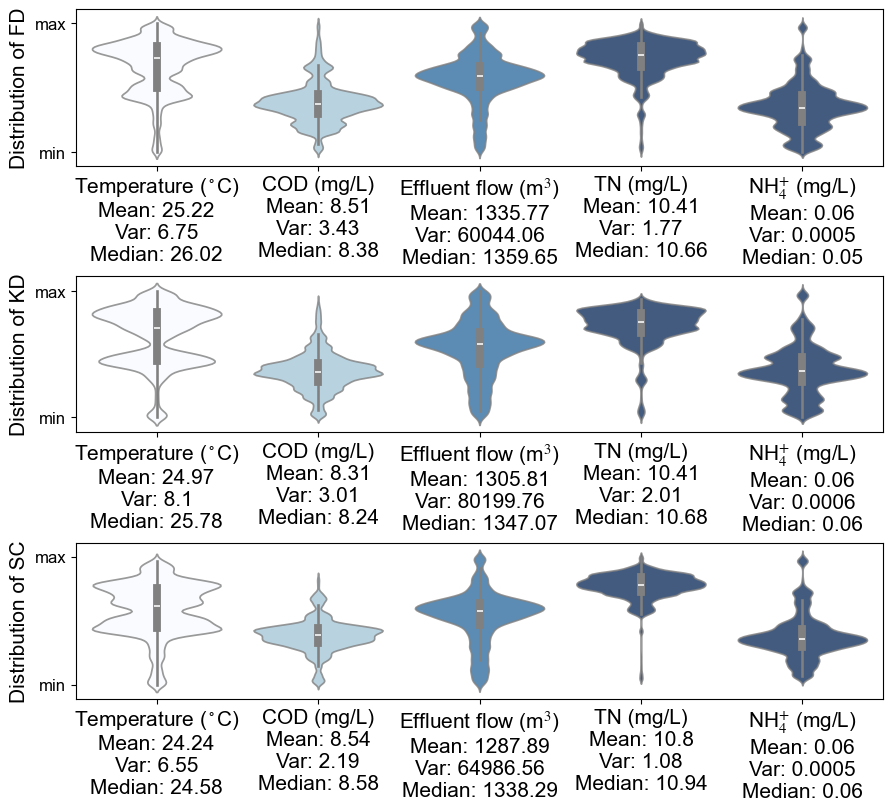

In [ ]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(25,8)
                )
gs = GridSpec(3, 3, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

alphas = [0.8, 0.4, 0.4, 0.4]
colors = ['#015482', '#61DE45', '#DEA13A', '#ff474c']#'#DE66C2''#5096DE'
label_size = 15
xticks_size = 15
colormap = plt.get_cmap('Blues')
colors   = colormap(np.linspace(0, 1.5, 5)).tolist() # 按百分比

ylabelsFD = ['Temperature ($^\circ$C)' + '\n' + 'Mean: '+str(np.round(np.mean(y,axis=0)[0],2))  + '\n' \
                + 'Var: '+str(np.round(np.var(y,axis=0)[0],2)) + '\n' + 'Median: '+str(np.round(np.median(y,axis=0)[0],2)),
             'COD (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(y,axis=0)[1],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(y,axis=0)[1],2)) + '\n' + 'Median: '+str(np.round(np.median(y,axis=0)[1],2)),
             'Effluent flow (m$^{3}$)' + '\n' + 'Mean: '+str(np.round(np.mean(y,axis=0)[2],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(y,axis=0)[2],2)) + '\n' + 'Median: '+str(np.round(np.median(y,axis=0)[2],2)), 
             'TN (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(y,axis=0)[3],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(y,axis=0)[3],2)) + '\n' + 'Median: '+str(np.round(np.median(y,axis=0)[3],2)),
             'NH$_{4}^{+}$ (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(y,axis=0)[4],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(y,axis=0)[4],4)) + '\n' + 'Median: '+str(np.round(np.median(y,axis=0)[4],2)),
             ]

ylabelsKD = ['Temperature ($^\circ$C)' + '\n' + 'Mean: '+str(np.round(np.mean(sy,axis=0)[0],2))  + '\n' \
                + 'Var: '+str(np.round(np.var(sy,axis=0)[0],2)) + '\n' + 'Median: '+str(np.round(np.median(sy,axis=0)[0],2)),
             'COD (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(sy,axis=0)[1],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(sy,axis=0)[1],2)) + '\n' + 'Median: '+str(np.round(np.median(sy,axis=0)[1],2)),
             'Effluent flow (m$^{3}$)' + '\n' + 'Mean: '+str(np.round(np.mean(sy,axis=0)[2],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(sy,axis=0)[2],2)) + '\n' + 'Median: '+str(np.round(np.median(sy,axis=0)[2],2)), 
             'TN (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(sy,axis=0)[3],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(sy,axis=0)[3],2)) + '\n' + 'Median: '+str(np.round(np.median(sy,axis=0)[3],2)),
             'NH$_{4}^{+}$ (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(sy,axis=0)[4],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(sy,axis=0)[4],4)) + '\n' + 'Median: '+str(np.round(np.median(sy,axis=0)[4],2)),
             ]

ylabelsSC = ['Temperature ($^\circ$C)' + '\n' + 'Mean: '+str(np.round(np.mean(cy,axis=0)[0],2))  + '\n' \
                + 'Var: '+str(np.round(np.var(cy,axis=0)[0],2)) + '\n' + 'Median: '+str(np.round(np.median(cy,axis=0)[0],2)),
             'COD (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(cy,axis=0)[1],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(cy,axis=0)[1],2)) + '\n' + 'Median: '+str(np.round(np.median(cy,axis=0)[1],2)),
             'Effluent flow (m$^{3}$)' + '\n' + 'Mean: '+str(np.round(np.mean(cy,axis=0)[2],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(cy,axis=0)[2],2)) + '\n' + 'Median: '+str(np.round(np.median(cy,axis=0)[2],2)), 
             'TN (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(cy,axis=0)[3],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(cy,axis=0)[3],2)) + '\n' + 'Median: '+str(np.round(np.median(cy,axis=0)[3],2)),
             'NH$_{4}^{+}$ (mg/L)' + '\n' + 'Mean: '+str(np.round(np.mean(cy,axis=0)[4],2)) + '\n' \
                + 'Var: '+str(np.round(np.var(cy,axis=0)[4],4)) + '\n' + 'Median: '+str(np.round(np.median(cy,axis=0)[4],2)),
             ]

fontsizes = [12, 12, 15]

data_maxmin = np.load('./Step1_datasplit/databygroup_maxmin.npy',allow_pickle=True).tolist()
dmax = np.round(data_maxmin['max'][[-5,-4,-3,-2,-1]],2)
dmin = np.round(data_maxmin['min'][[-5,-4,-3,-2,-1]],2)
dmid = np.round((dmax+dmin)/2,2)

dy1 = pd.DataFrame(ytrain,columns=['a','b','c','d','e'])
dy2 = pd.DataFrame(sytrain,columns=['a','b','c','d','e'])
dy3 = pd.DataFrame(cytrain,columns=['a','b','c','d','e'])


ax = fig.add_subplot(gs[0, 0])
sns.violinplot(data=dy1, palette=colors, edgecolor="gray", alpha=0.8)
ax.set_xticks([])
ax.set_yticks([-1,1],['min','max'])
ax.set_xticks([0,1,2,3,4],ylabelsFD,fontsize = xticks_size)
ax.set_ylabel('Distribution of FD',fontsize = label_size)

ax = fig.add_subplot(gs[1, 0])
sns.violinplot(data=dy2, palette=colors, edgecolor="gray", alpha=0.8)
ax.set_xticks([])
ax.set_yticks([-1,1],['min','max'])
ax.set_xticks([0,1,2,3,4],ylabelsKD,fontsize = xticks_size)
ax.set_ylabel('Distribution of KD',fontsize = label_size)

ax = fig.add_subplot(gs[2, 0])
sns.violinplot(data=dy3, palette=colors, edgecolor="gray", alpha=0.8)
ax.set_yticks([-1,1],['min','max'])
ax.set_xticks([0,1,2,3,4],ylabelsSC,fontsize = xticks_size)
ax.set_ylabel('Distribution of SC',fontsize = label_size)

plt.savefig('./DATA_dis.png',dpi=300,bbox_inches='tight')
